In [1]:
# -- Import data from BigQuery -- #
import pandas_gbq

project_id = 'data-science-398321'
query = """
SELECT 
  PARSE_DATE('%Y-%d-%m', CAST(ACTUAL_DATE AS STRING)) AS ACTUAL_DATE,
  * EXCEPT(ACTUAL_DATE)
FROM `data-science-398321.prod_public_gcs.fact_jobs_online_monthly_unadjusted_series`
"""

df = pandas_gbq.read_gbq(query, project_id=project_id)

Downloading: 100%|██████████|


In [2]:
# -- Extract basic info from the dataset -- #
def extract_basic_info(df):
    # number of instances and attributes
    rows, cols = df.shape
    
    # number of numerical and categorical attributes
    num_cols = df.select_dtypes(include=['number']).shape[1]
    cat_cols = df.select_dtypes(exclude=['number']).shape[1]

    # memory size (MB)
    mem_size = round(df.memory_usage(deep=True).sum() / (1024 ** 2), 2)

    # return a tuple
    return rows, cols, num_cols, cat_cols, mem_size

In [3]:
# Print the basic info
rows, cols, num_cols, cat_cols, mem_size = extract_basic_info(df)

print('----- Basic info -----')
print('Number of instances:', rows)
print('Number of attributes:', cols)
print('Number of numerical attributes:', num_cols)
print('Number of categorical attributes:', cat_cols)
print('Memory size (MB):', mem_size)

----- Basic info -----
Number of instances: 222
Number of attributes: 33
Number of numerical attributes: 32
Number of categorical attributes: 1
Memory size (MB): 0.06


In [4]:
df.head(5)

,ACTUAL_DATE,TOTALS,ANNUAL_CHANGE,SkilledIndex,UnskilledIndex,Auckland,Wellington,North_Island_Other,Canterbury,South_Island_Other,...,Community_and_Personal_Service_Workers,Clerical_and_Administrative_Workers,Sales_Workers,Machinery_Operators_and_Drivers,Labourers,Highly_Skilled,Skilled,Semi_Skilled,Low_Skilled,Unskilled
0,2007-05-01,100.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,2007-06-01,92.1,NaN,91.5,92.5,91.8,93.5,94.4,94.1,76.6,...,91.7,95.2,93.8,80.2,89.2,91.2,92.8,89.6,92.8,91.2
2,2007-07-01,95.7,NaN,95.3,94.9,96.4,95.1,95.5,98.6,84.0,...,97.3,95.9,98.7,92.3,89.5,95.1,93.7,101.7,94.1,97.4
3,2007-08-01,103.2,NaN,102.0,103.1,101.2,98.8,113.3,109.5,106.4,...,122.7,103.5,98.6,109.6,110.8,97.7,110.8,111.6,103.1,102.8
4,2007-09-01,97.0,NaN,96.7,96.4,93.9,95.1,105.7,103.9,107.4,...,111.7,90.8,96.9,104.7,103.5,91.1,112.1,98.8,95.3,100.2


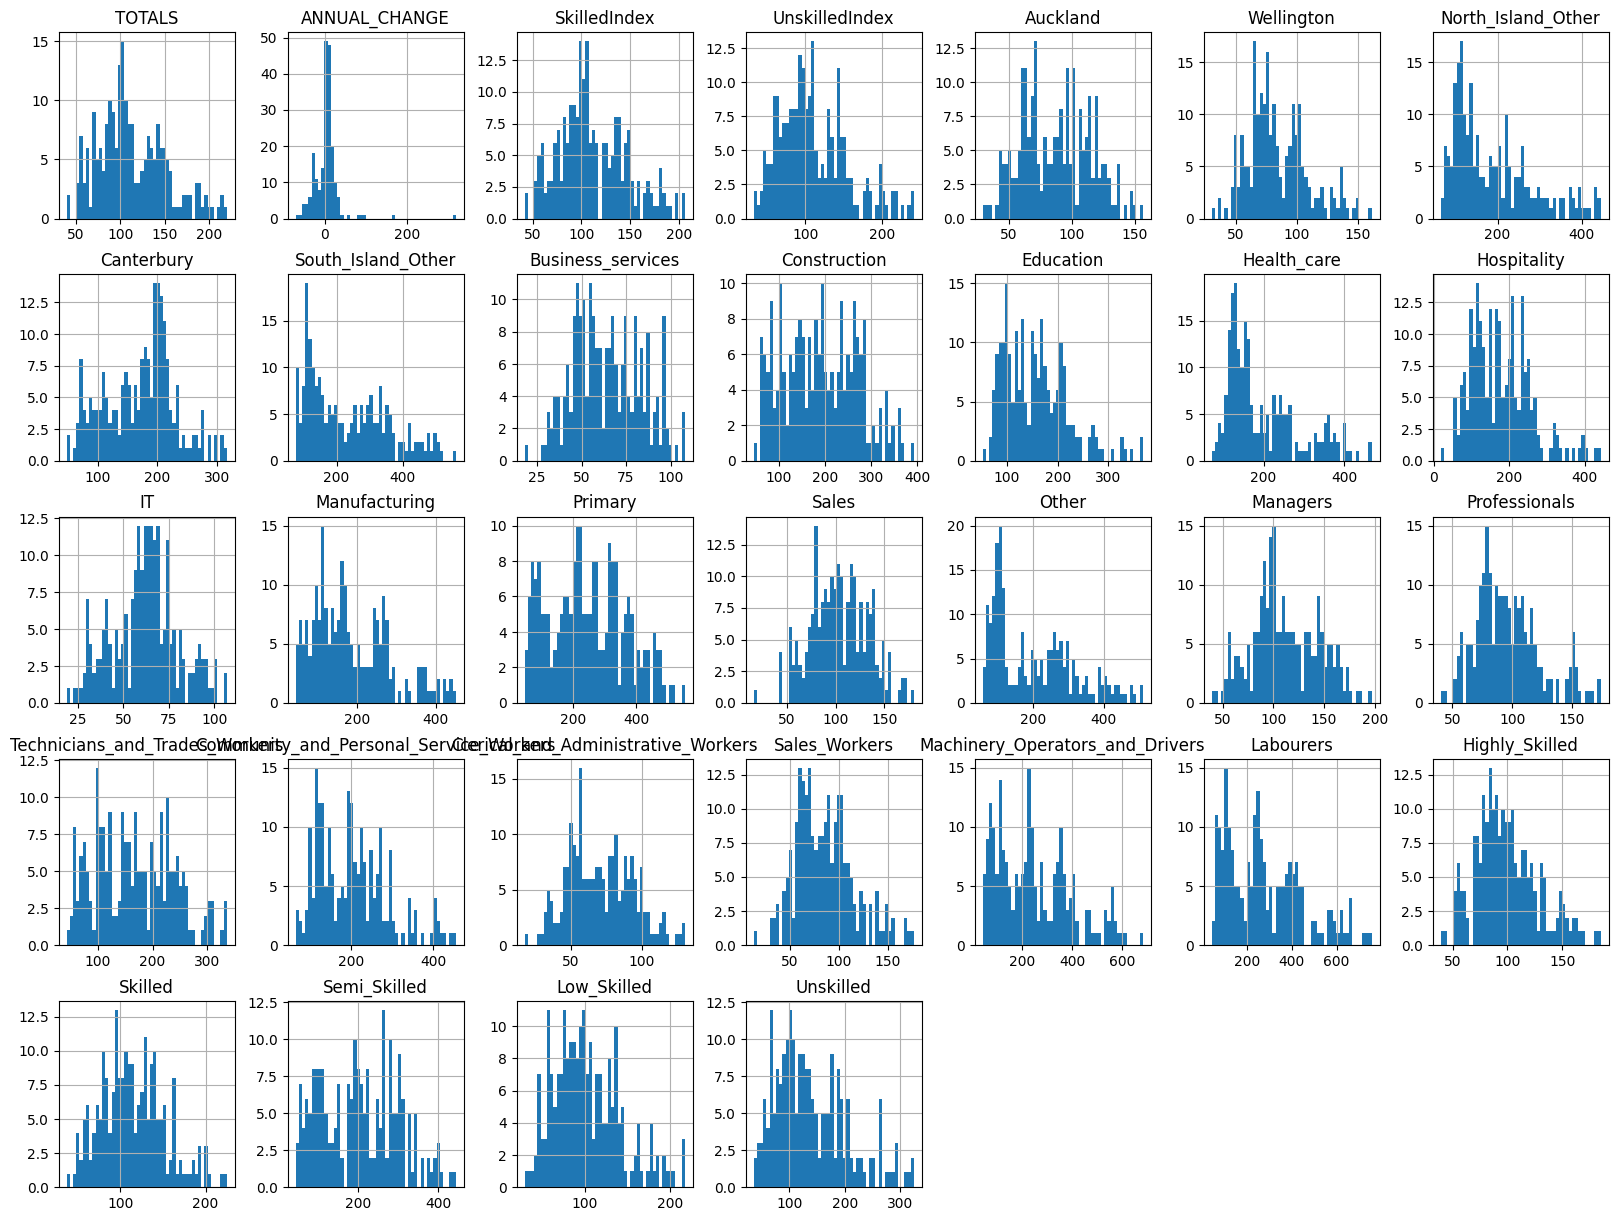

In [5]:
# -- Histograms of numerical attributes -- #
import pandas as pd
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['number'])
numeric_df.hist(bins=50, figsize=(20, 15), layout=(5, 7))

plt.show()

Text(0.5, 1.0, 'Job Vacancies Index Over Months')

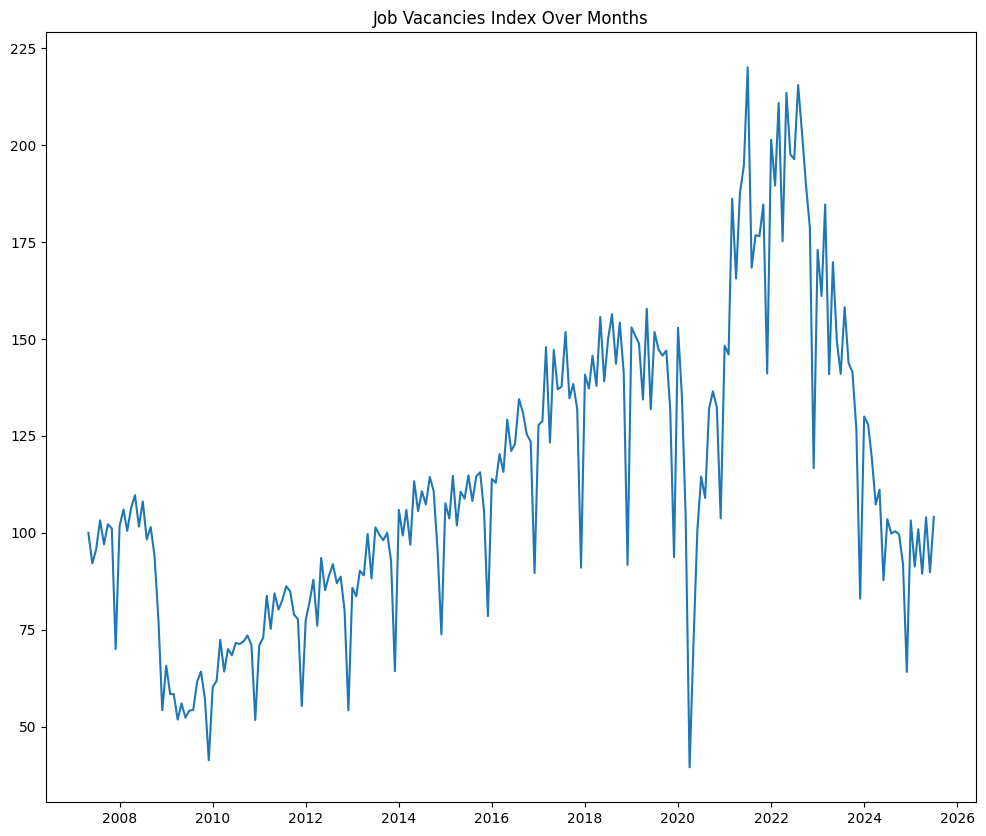

In [6]:
# -- Monthly job vacancies index -- #
df['ACTUAL_DATE'] = pd.to_datetime(df['ACTUAL_DATE'], dayfirst=True)

plt.figure(figsize=(12, 10))
plt.plot(df['ACTUAL_DATE'], df['TOTALS'])
plt.title('Job Vacancies Index Over Months')

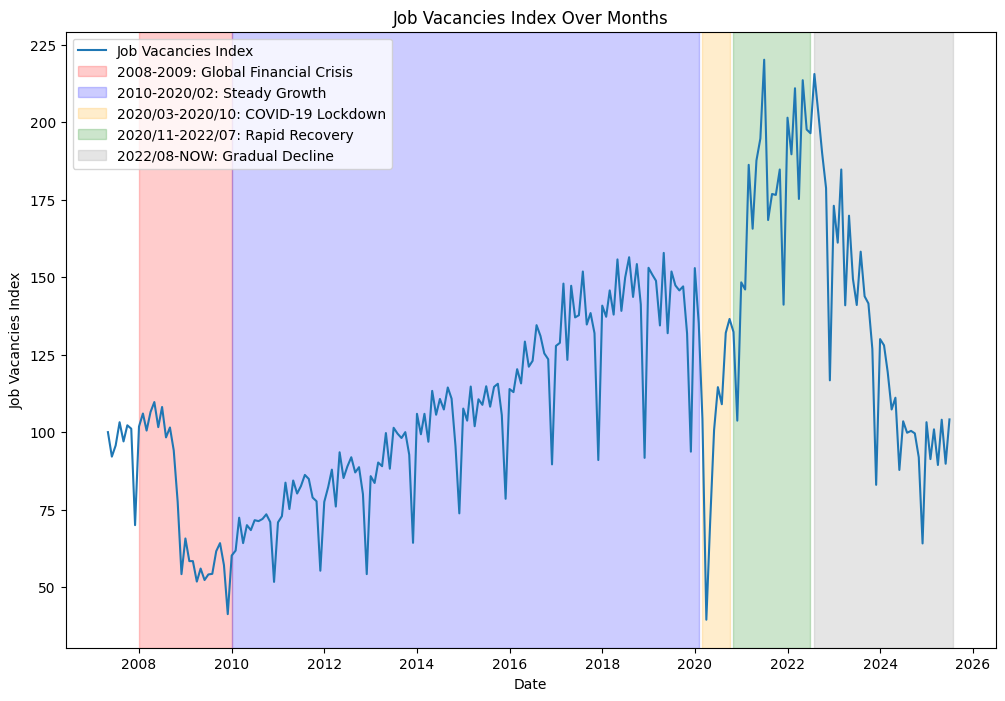

In [7]:
# Monthly job vacancies index with shaded regions
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(df['ACTUAL_DATE'], df['TOTALS'], label='Job Vacancies Index')

# Add shaded regions for periods
plt.axvspan(pd.to_datetime('2008-01-01'), pd.to_datetime('2009-12-31'), color='red', alpha=0.2, label='2008-2009: Global Financial Crisis')
plt.axvspan(pd.to_datetime('2010-01-01'), pd.to_datetime('2020-02-01'), color='blue', alpha=0.2, label='2010-2020/02: Steady Growth')
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2020-10-01'), color='orange', alpha=0.2, label='2020/03-2020/10: COVID-19 Lockdown')
plt.axvspan(pd.to_datetime('2020-11-01'), pd.to_datetime('2022-07-01'), color='green', alpha=0.2, label='2020/11-2022/07: Rapid Recovery')
plt.axvspan(pd.to_datetime('2022-08-01'), pd.to_datetime('2025-08-01'), color='grey', alpha=0.2, label='2022/08-NOW: Gradual Decline')

# Add title and labels
plt.title('Job Vacancies Index Over Months')
plt.xlabel('Date')
plt.ylabel('Job Vacancies Index')
plt.legend(loc='upper left')

# Show the plot
plt.show()

In [8]:
"""
* **2008–2009**: Global Financial Crisis → sharp drop in vacancies.
* **2010–2020/02**: Steady growth.
* **2020/3-2020/10**:  COVID-19 lockdown caused a major fall.
* **2020/11–2022/07**: Rapid recovery due to eased restrictions and border closure, leading to labour shortages and record-high vacancies.
* **2022/08-NOW**: Gradual decline as borders reopened and overseas labour filled gaps.
"""

'\n* **2008–2009**: Global Financial Crisis → sharp drop in vacancies.\n* **2010–2020/02**: Steady growth.\n* **2020/3-2020/10**:  COVID-19 lockdown caused a major fall.\n* **2020/11–2022/07**: Rapid recovery due to eased restrictions and border closure, leading to labour shortages and record-high vacancies.\n* **2022/08-NOW**: Gradual decline as borders reopened and overseas labour filled gaps.\n'

In [9]:
# -- Seasonality: overall -- #
# Remove two dramatic reductions (2008 Global Financial Crisis and 2020 COVID-19 Pandemic)
# Split the dataset into two parts: increasing and decreasing (before and after the Pandemic)
import pandas as pd

inc_date_start = pd.to_datetime('2010-01-01')
inc_date_end = pd.to_datetime('2019-12-31')

dec_date_start = pd.to_datetime('2023-01-01')
dec_date_end = pd.to_datetime('2025-07-31')

inc_df = df[df['ACTUAL_DATE'].between(inc_date_start, inc_date_end)].set_index('ACTUAL_DATE')
dec_df = df[df['ACTUAL_DATE'].between(dec_date_start, dec_date_end)].set_index('ACTUAL_DATE')

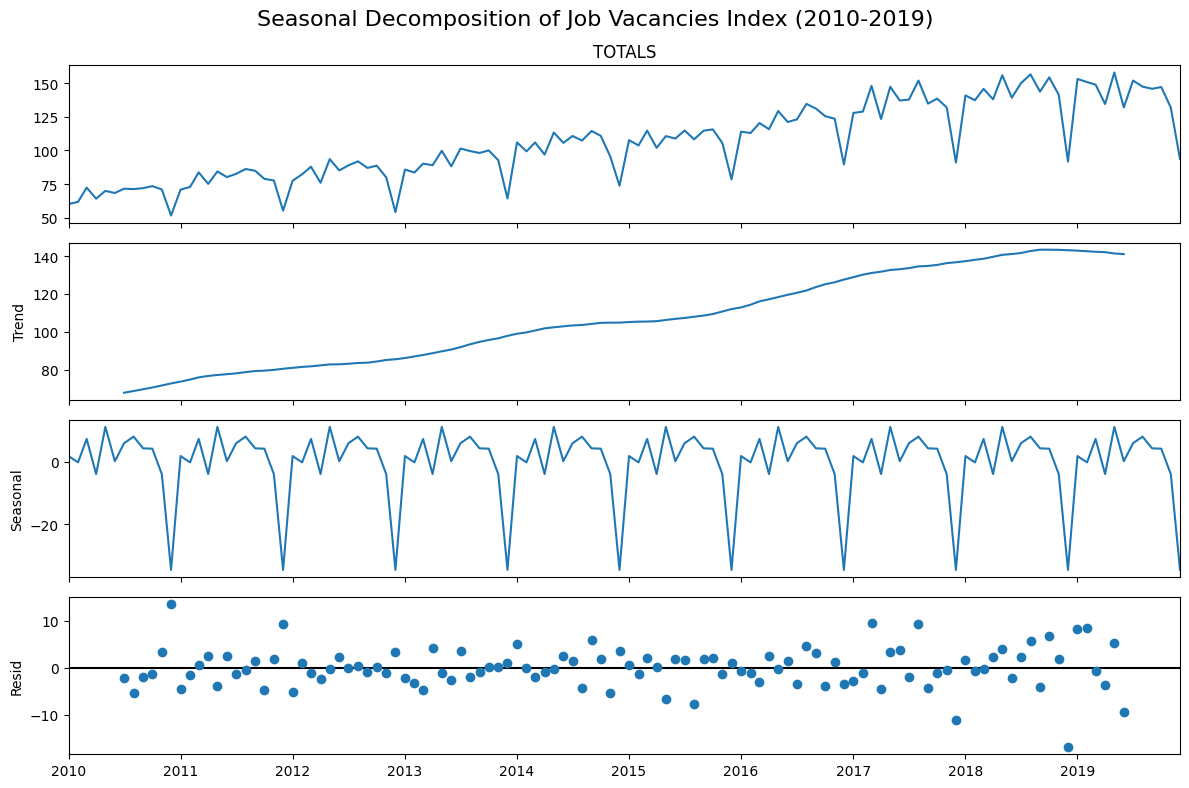

In [10]:
# Seasonal decompose in uptrend years
from statsmodels.tsa.seasonal import seasonal_decompose

inc_result = seasonal_decompose(inc_df['TOTALS'], model='additive', period=12) # monthly=12, weekly=52

plt.rcParams.update({'figure.figsize': (12, 8)})
inc_result.plot()
plt.suptitle(f'Seasonal Decomposition of Job Vacancies Index ({inc_date_start.year}-{inc_date_end.year})', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# Monthly average seasonal values
inc_seasonal = inc_result.seasonal
inc_monthly_avg = inc_seasonal.groupby(inc_seasonal.index.month).mean()

# Top k / Bottom k 
k = 5
top_k_months = inc_monthly_avg.sort_values(ascending=False).head(k).round(2)
bottom_k_months = inc_monthly_avg.sort_values().head(k).round(2)

print("Top months (highest seasonal avg):")
print(top_k_months)

print("\nBottom months (lowest seasonal avg):")
print(bottom_k_months)


Top months (highest seasonal avg):
ACTUAL_DATE
5    11.11
8     8.01
3     7.27
7     5.90
9     4.26
Name: seasonal, dtype: float64

Bottom months (lowest seasonal avg):
ACTUAL_DATE
12   -34.54
11    -3.97
4     -3.94
2     -0.23
6      0.16
Name: seasonal, dtype: float64


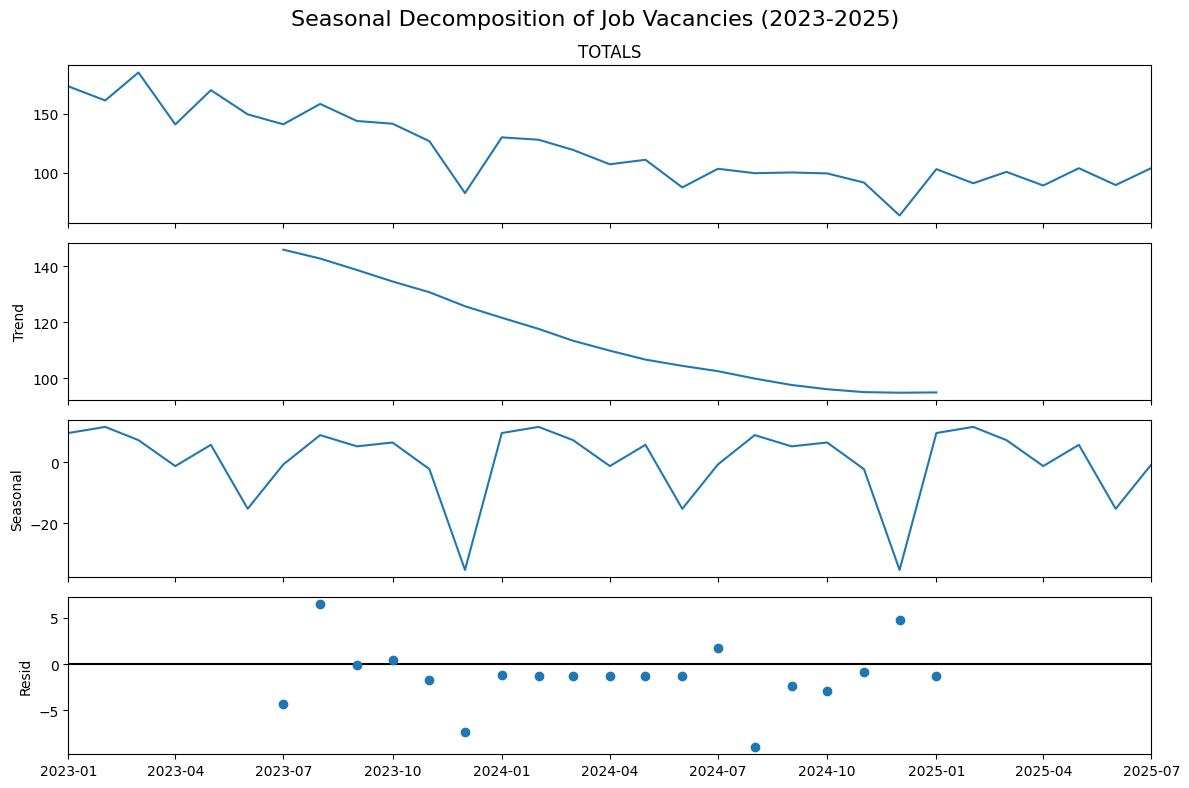

In [12]:
# Seasonal decomposition in downtrend years
from statsmodels.tsa.seasonal import seasonal_decompose

dec_result = seasonal_decompose(dec_df['TOTALS'], model='additive', period=12) #, two_sided=False, extrapolate_trend='freq') # monthly=12, weekly=52

plt.rcParams.update({'figure.figsize': (12, 8)})
dec_result.plot()
plt.suptitle(f'Seasonal Decomposition of Job Vacancies ({dec_date_start.year}-{dec_date_end.year})', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
# Monthly average seasonal values
dec_seasonal = dec_result.seasonal
dec_monthly_avg = dec_seasonal.groupby(dec_seasonal.index.month).mean()

# Top k / Bottom k 
k = 5
top_k_months = dec_monthly_avg.sort_values(ascending=False).head(k).round(2)
bottom_k_months = dec_monthly_avg.sort_values().head(k).round(2)

print("Top months (highest seasonal avg):")
print(top_k_months)

print("\nBottom months (lowest seasonal avg):")
print(bottom_k_months)


Top months (highest seasonal avg):
ACTUAL_DATE
2     11.65
1      9.62
8      8.94
3      7.29
10     6.51
Name: seasonal, dtype: float64

Bottom months (lowest seasonal avg):
ACTUAL_DATE
12   -35.44
6    -15.32
11    -2.25
4     -1.26
7     -0.72
Name: seasonal, dtype: float64


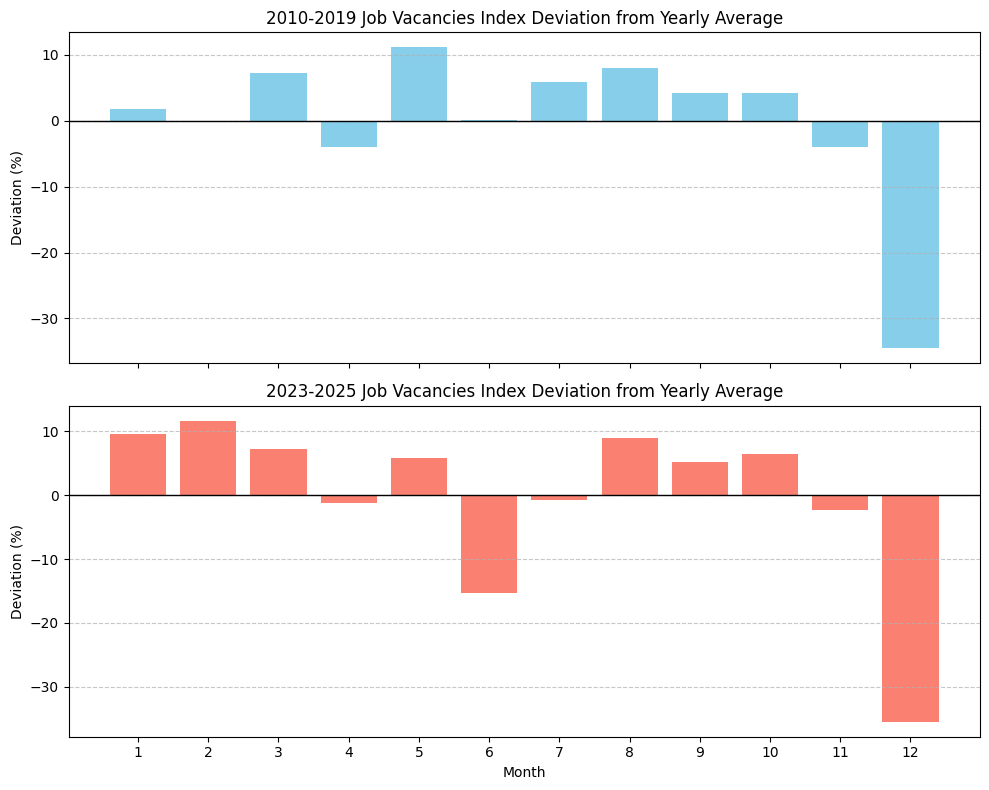

In [14]:
# Seasonal decomposition visualisation
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for increasing period
axes[0].bar(inc_monthly_avg.index, inc_monthly_avg.values, color='skyblue')
axes[0].axhline(0, color='black', linewidth=1)
axes[0].set_ylabel('Deviation (%)')
axes[0].set_title(f'{inc_date_start.year}-{inc_date_end.year} Job Vacancies Index Deviation from Yearly Average')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for decreasing period
axes[1].bar(dec_monthly_avg.index, dec_monthly_avg.values, color='salmon')
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Deviation (%)')
axes[1].set_title(f'{dec_date_start.year}-{dec_date_end.year} Job Vacancies Index Deviation from Yearly Average')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

In [15]:
"""
Before 2020, when the job vacancies were structurally increasing, peak months were mainly in March, May, and July-September, while the lowest months were April, November, and especially December.

After 2023, when vacancies began structurally decreasing, peak months shifted earlier to January-March, May, and August-October, while the weakest months became June, November, and December.
"""

'\nBefore 2020, when the job vacancies were structurally increasing, peak months were mainly in March, May, and July-September, while the lowest months were April, November, and especially December.\n\nAfter 2023, when vacancies began structurally decreasing, peak months shifted earlier to January-March, May, and August-October, while the weakest months became June, November, and December.\n'

In [16]:
# -- Seasonality: all columns -- #
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt

def decompose_all_columns(df, period=12, model='additive', two_sided=True, extrapolate_trend=0, plot=False):
    """
    Perform seasonal decomposition for each column in a DataFrame,
    and output a long-format DataFrame with observed, trend, seasonal, and residual components.

    Parameters
    ----------
    df : pd.DataFrame
        Time series data. Index must be a DatetimeIndex.
    period : int
        Seasonal period (e.g., 12 for monthly data, 52 for weekly data).
    model : str
        Decomposition model: 'additive' or 'multiplicative'.
    two_sided : bool
        Whether to use a centered moving average (True) or past values only (False).
    extrapolate_trend : str or int
        Whether and how to extrapolate the trend component.
    plot : bool
        If True, plot the seasonal decomposition for each column.

    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        date, subcategory(raw column), observed, trend, seasonal, resid
    """
    all_results = []

    for col in df.columns:
        result = seasonal_decompose(
            df[col],
            model=model,
            period=period,
            two_sided=two_sided,
            extrapolate_trend=extrapolate_trend
        )

        # Convert to long-format DataFrame
        tmp = pd.DataFrame({
            'observed': result.observed,
            'trend': result.trend,
            'seasonal': result.seasonal,
            'resid': result.resid
        })
        tmp['subcategory'] = col
        tmp['date'] = tmp.index
        all_results.append(tmp)

    results_df = pd.concat(all_results, ignore_index=True)
    results_df = results_df[['date', 'subcategory', 'observed', 'trend', 'seasonal', 'resid']]

    return results_df


In [17]:
# Define category mappings
import pandas_gbq

project_id = 'data-science-398321'
query = """
SELECT 
  category,
  subcategory
FROM `data-science-398321.data_lab_eric_tseng.dim_jobs_online_category_mapping_view`
"""

category_df = pandas_gbq.read_gbq(query, project_id=project_id)


Downloading: 100%|██████████|


In [18]:
# Select relevant columns for analysis
def select_valid_columns(df, candidates):
    return [col for col in df.columns if col in candidates]

col_selected = category_df['subcategory'].to_list()
inc_cols = select_valid_columns(inc_df, col_selected)
dec_cols = select_valid_columns(dec_df, col_selected)

# Append categories
def append_categories(df, category_df):    
    merged_df = df.merge(
        category_df,
        on="subcategory",      # subcategory as key
        how="left"             # left join
    )
    return merged_df

# Seasonal decomposition for selected columns
inc_seasonal_results = decompose_all_columns(inc_df[inc_cols], period=12)
inc_seasonal_results = append_categories(inc_seasonal_results, category_df)
inc_seasonal_results = inc_seasonal_results[['date', 'category', 'subcategory', 'observed', 'trend', 'seasonal', 'resid']]
print(inc_seasonal_results.head(5))

dec_seasonal_results = decompose_all_columns(dec_df[dec_cols], period=12)
dec_seasonal_results = append_categories(dec_seasonal_results, category_df)
dec_seasonal_results = dec_seasonal_results[['date', 'category', 'subcategory', 'observed', 'trend', 'seasonal', 'resid']]
print(dec_seasonal_results.head(5))

        date category subcategory  observed  trend   seasonal  resid
0 2010-01-01    Total      TOTALS      60.2    NaN   1.808488    NaN
1 2010-02-01    Total      TOTALS      61.8    NaN  -0.225772    NaN
2 2010-03-01    Total      TOTALS      72.4    NaN   7.270062    NaN
3 2010-04-01    Total      TOTALS      64.2    NaN  -3.944753    NaN
4 2010-05-01    Total      TOTALS      70.0    NaN  11.111265    NaN
        date category subcategory  observed  trend   seasonal  resid
0 2023-01-01    Total      TOTALS     173.0    NaN   9.623264    NaN
1 2023-02-01    Total      TOTALS     161.1    NaN  11.646181    NaN
2 2023-03-01    Total      TOTALS     184.7    NaN   7.287847    NaN
3 2023-04-01    Total      TOTALS     140.9    NaN  -1.257986    NaN
4 2023-05-01    Total      TOTALS     169.8    NaN   5.742014    NaN


In [19]:
# Check missing mappings
inc_missing = inc_seasonal_results[inc_seasonal_results['category'].isna()]['subcategory'].unique()
dec_missing = dec_seasonal_results[dec_seasonal_results['category'].isna()]['subcategory'].unique()
print("Missing mappings (uptrend years):", inc_missing)
print("Missing mappings (downtrend years):", inc_missing)


Missing mappings (uptrend years): []
Missing mappings (downtrend years): []


In [20]:
# Seasonal monthly average
inc_seasonal_avg = inc_seasonal_results.copy()
inc_seasonal_avg['month'] = inc_seasonal_avg['date'].dt.month

dec_seasonal_avg = dec_seasonal_results.copy()
dec_seasonal_avg['month'] = dec_seasonal_avg['date'].dt.month

inc_seasonal_avg = (
    inc_seasonal_avg.groupby(['category', 'subcategory', 'month'])['seasonal']
    .mean()
    .reset_index()
)
print(inc_seasonal_avg.head(5))

dec_seasonal_avg = (
    dec_seasonal_avg.groupby(['category', 'subcategory', 'month'])['seasonal']
    .mean()
    .reset_index()
)
print(dec_seasonal_avg.head(5))

   category        subcategory  month   seasonal
0  Industry  Business_services      1  -0.110031
1  Industry  Business_services      2  -0.023920
2  Industry  Business_services      3   6.283025
3  Industry  Business_services      4   0.072377
4  Industry  Business_services      5  10.694136
   category        subcategory  month  seasonal
0  Industry  Business_services      1  4.215625
1  Industry  Business_services      2  5.226042
2  Industry  Business_services      3  6.367708
3  Industry  Business_services      4  4.101042
4  Industry  Business_services      5  8.005208


In [21]:
# -- Seasonality similarity -- #
from sklearn.metrics.pairwise import cosine_similarity

inc_seasonal_pivot = inc_seasonal_avg.pivot_table(
    index=['category', 'subcategory'],
    columns='month',
    values='seasonal'
)
inc_seasonal_similarity  = pd.DataFrame(
    cosine_similarity(inc_seasonal_pivot),
    index=inc_seasonal_pivot.index,
    columns=inc_seasonal_pivot.index
)

dec_seasonal_pivot = dec_seasonal_avg.pivot_table(
    index=['category', 'subcategory'],
    columns='month',
    values='seasonal'
)
dec_seasonal_similarity  = pd.DataFrame(
    cosine_similarity(dec_seasonal_pivot),
    index=dec_seasonal_pivot.index,
    columns=dec_seasonal_pivot.index
)

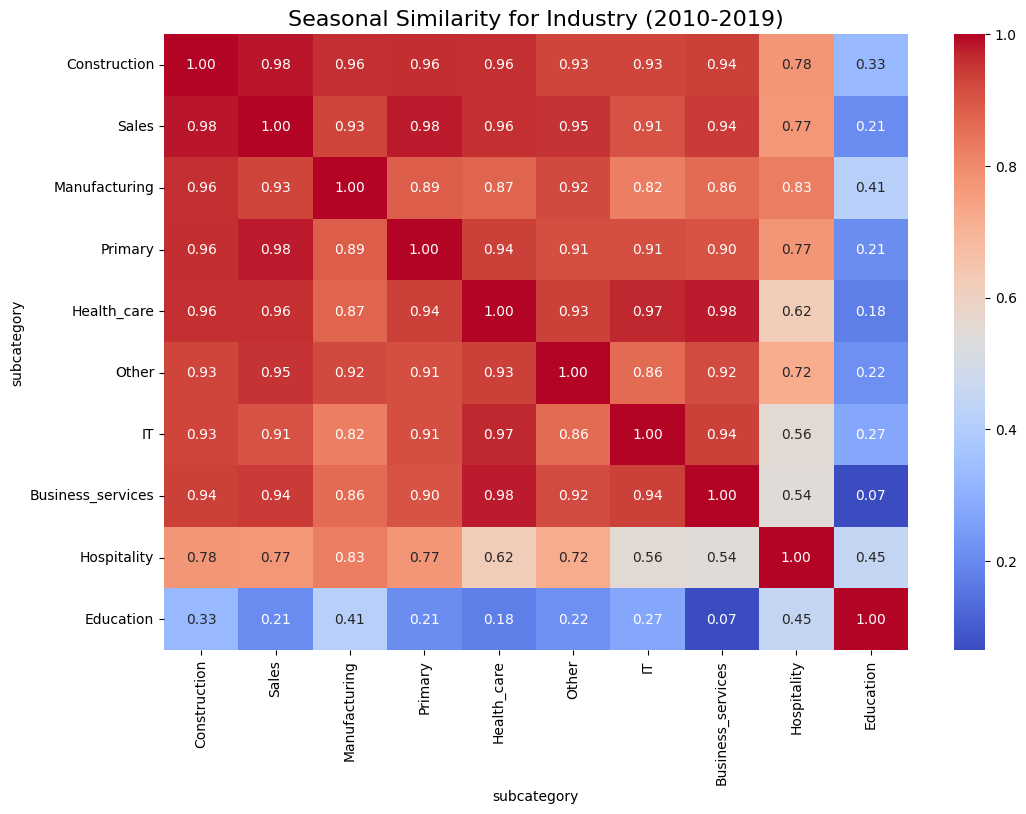

In [22]:
# Heatmap for the similarity: uptrend years
import seaborn as sns
import matplotlib.pyplot as plt

cat = 'Industry'
sub = (inc_seasonal_similarity
       .xs(cat, level='category', axis=0)
       .xs(cat, level='category', axis=1))
sub.index = sub.index.get_level_values('subcategory')
sub.columns = sub.columns.get_level_values('subcategory')

# Reorder by the mean of similarity
avg_similarity = sub.mean(axis=1).sort_values(ascending=False)
sub_sorted = sub.loc[avg_similarity.index, avg_similarity.index]

plt.figure(figsize=(12, 8))
sns.heatmap(sub_sorted, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
plt.title(f"Seasonal Similarity for {cat} ({inc_date_start.year}-{inc_date_end.year})", fontsize=16)
plt.show()


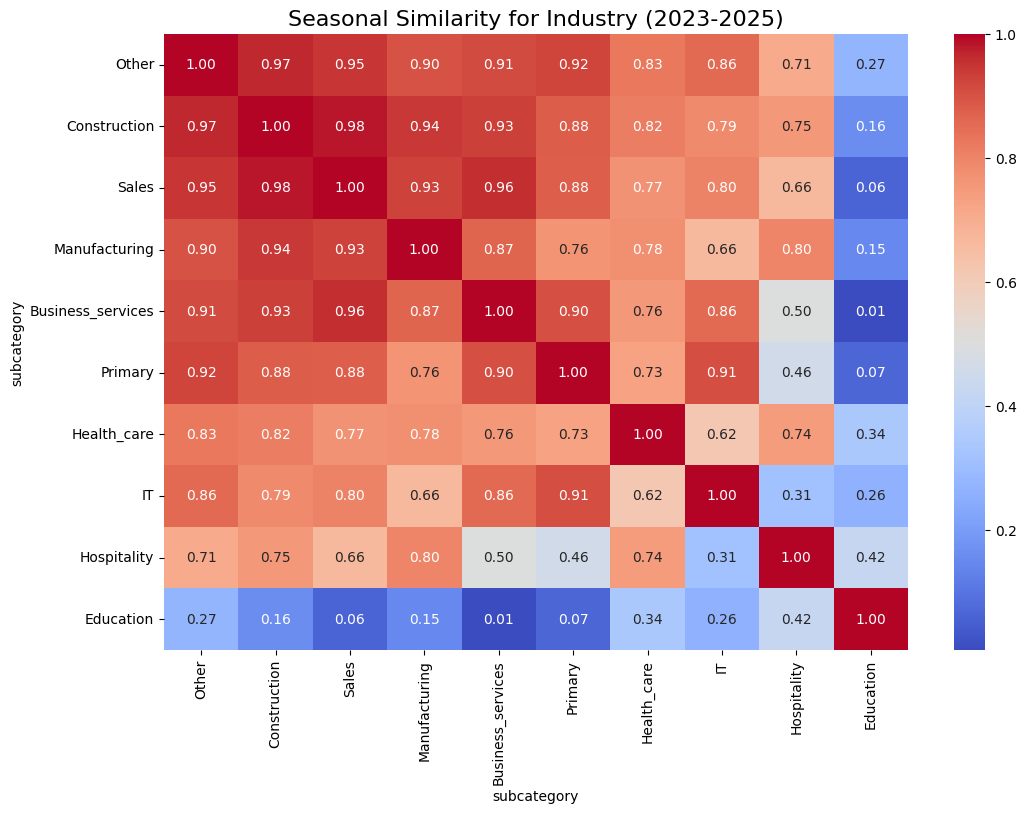

In [23]:
# Heatmap for the similarity: downtrend years
import seaborn as sns
import matplotlib.pyplot as plt

cat = 'Industry'
sub = (dec_seasonal_similarity
       .xs(cat, level='category', axis=0)
       .xs(cat, level='category', axis=1))
sub.index = sub.index.get_level_values('subcategory')
sub.columns = sub.columns.get_level_values('subcategory')

# Reorder by the mean of similarity
avg_similarity = sub.mean(axis=1).sort_values(ascending=False)
sub_sorted = sub.loc[avg_similarity.index, avg_similarity.index]

plt.figure(figsize=(12, 8))
sns.heatmap(sub_sorted, cmap='coolwarm', annot=True, fmt='.2f', cbar=True)
plt.title(f"Seasonal Similarity for {cat} ({dec_date_start.year}-{dec_date_end.year})", fontsize=16)
plt.show()



In [24]:
"""
Both Hospitality and Education show different seasonal patterns compared to other industries.<br>
Therefore, the seasonal analysis should be conducted separately for these categories.
"""

'\nBoth Hospitality and Education show different seasonal patterns compared to other industries.<br>\nTherefore, the seasonal analysis should be conducted separately for these categories.\n'

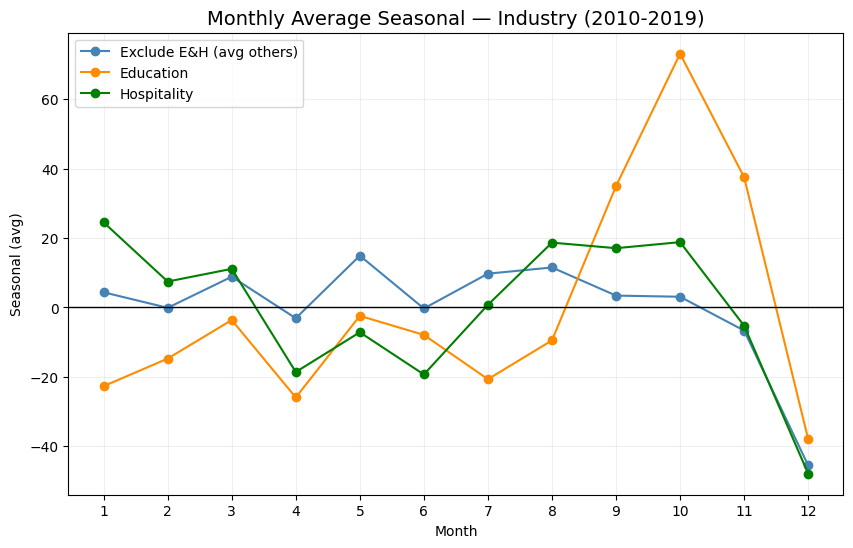

In [25]:
# -- Seasonality split by industry: uptrend years -- #
import pandas as pd
import matplotlib.pyplot as plt

cat = "Industry"
special = ["Education", "Hospitality"]

# Seasonal monthly average for the specific category
base = inc_seasonal_avg[inc_seasonal_avg["category"] == cat].copy()

# (1) Exclude E & H 
others = (base[~base["subcategory"].isin(special)]
          .groupby("month")["seasonal"].mean()
          .reindex(range(1,13)))

# (2) Education & Hospitality 
edu = (base[base["subcategory"]=="Education"]
       .set_index("month")["seasonal"]
       .reindex(range(1,13)))
hosp = (base[base["subcategory"]=="Hospitality"]
        .set_index("month")["seasonal"]
        .reindex(range(1,13)))

# Visualisation
plt.figure(figsize=(10,6))

plt.plot(others.index, others.values, marker="o", label="Exclude E&H (avg others)", color="steelblue")
plt.plot(edu.index, edu.values, marker="o", label="Education", color="darkorange")
plt.plot(hosp.index, hosp.values, marker="o", label="Hospitality", color="green")

plt.axhline(0, color="black", linewidth=1)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Seasonal (avg)")
plt.title(f"Monthly Average Seasonal — {cat} ({inc_date_start.year}-{inc_date_end.year})", fontsize=14)
plt.grid(True, alpha=0.2)
plt.legend()

plt.show()


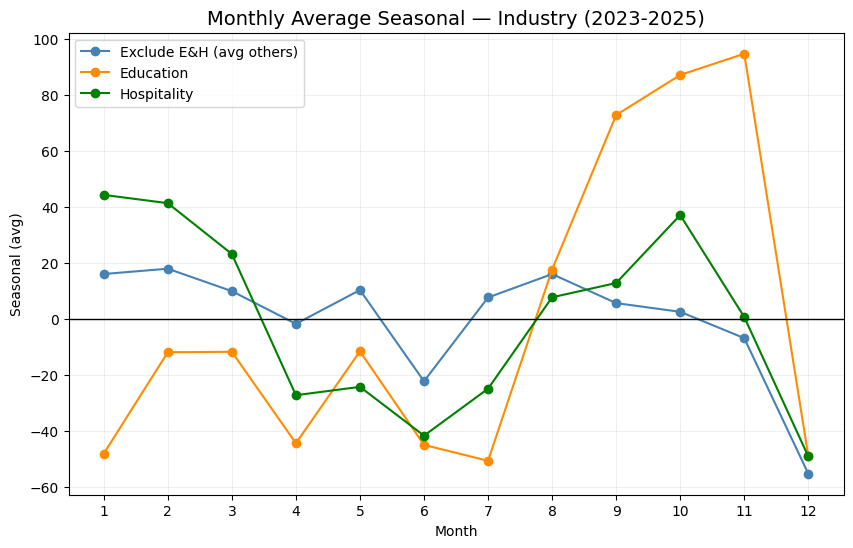

In [26]:
# -- Seasonality split by industry: downtrend years -- #
import pandas as pd
import matplotlib.pyplot as plt

cat = "Industry"
special = ["Education", "Hospitality"]

# Seasonal monthly average for the specific category
base = dec_seasonal_avg[dec_seasonal_avg["category"] == cat].copy()

# (1) Exclude E & H 
others = (base[~base["subcategory"].isin(special)]
          .groupby("month")["seasonal"].mean()
          .reindex(range(1,13)))

# (2) Education & Hospitality 
edu = (base[base["subcategory"]=="Education"]
       .set_index("month")["seasonal"]
       .reindex(range(1,13)))
hosp = (base[base["subcategory"]=="Hospitality"]
        .set_index("month")["seasonal"]
        .reindex(range(1,13)))

# Visualisation
plt.figure(figsize=(10,6))

plt.plot(others.index, others.values, marker="o", label="Exclude E&H (avg others)", color="steelblue")
plt.plot(edu.index, edu.values, marker="o", label="Education", color="darkorange")
plt.plot(hosp.index, hosp.values, marker="o", label="Hospitality", color="green")

plt.axhline(0, color="black", linewidth=1)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Seasonal (avg)")
plt.title(f"Monthly Average Seasonal — {cat} ({dec_date_start.year}-{dec_date_end.year})", fontsize=14)
plt.grid(True, alpha=0.2)
plt.legend()

plt.show()


In [27]:
# -- Seasonality residual -- #
# If it's high, we may not see the seasonal patterns are stable
import pandas as pd
import numpy as np

def residual_summary(results_df, category):
    # specific category
    df_cat = results_df[results_df["category"] == category].copy()
    
    # rmse
    summary = (df_cat.groupby("subcategory")
               .apply(lambda g: pd.Series({
                   "rmse": np.sqrt(np.mean(g["resid"].dropna()**2)),
                   "mae": g["resid"].abs().mean(),
                   "mape": (g["resid"].abs() / g["observed"].replace(0, np.nan).abs()).mean() * 100,
                   "resid_to_obs": (g["resid"].abs().sum() / g["observed"].abs().sum()) * 100
               }))
               .reset_index())
    return summary

In [28]:
# Build the residual visualisation
import matplotlib.pyplot as plt
import seaborn as sns

def residual_visualisation(resid_df, category, date_start, date_end):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    order = resid_df.sort_values("mape", ascending=False)["subcategory"]

    # Bar plot: MAPE
    sns.barplot(
        data=resid_df, x="subcategory", y="mape",
        order=order, ax=ax1, color="skyblue"
    )
    ax1.set_ylabel("Residual MAPE (%)")
    ax1.set_xticklabels(order, rotation=45)

    # Line plot: Residual / Observed (%)
    ax2 = ax1.twinx()
    ax2.plot(
        range(len(order)),
        resid_df.set_index("subcategory").loc[order]["resid_to_obs"].values,
        marker="o", color="red", linewidth=2, label="Residual / Observed (%)"
    )
    ax2.set_ylabel("Residual / Observed (%)")
    ax2.legend(loc="upper right")

    title = f"Residual size per subcategory"
    if category:
        title += f" - {category}"
    if date_start and date_end:
        title += f" ({date_start}-{date_end})"
    ax1.set_title(title)

    plt.show()


/var/tmp/ipykernel_6061/1160932187.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/tmp/ipykernel_6061/4108730091.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(order, rotation=45)


         subcategory       rmse        mae      mape  resid_to_obs
7              Other  19.059607  11.842161  8.034429      6.398222
8            Primary  16.546046  12.808849  6.187811      5.083082
2          Education  11.455730   8.447988  6.795593      5.718439
6      Manufacturing  10.962689   7.864738  6.380125      4.321328
1       Construction   9.250135   6.936821  4.420690      3.396271
4        Hospitality   8.734486   6.964296  4.516568      3.726972
3        Health_care   7.739010   5.614155  3.647360      3.138688
9              Sales   4.739208   3.682230  3.543668      3.086074
5                 IT   2.822136   2.258160  3.663068      3.228591
0  Business_services   2.486763   1.913837  3.290104      2.821844


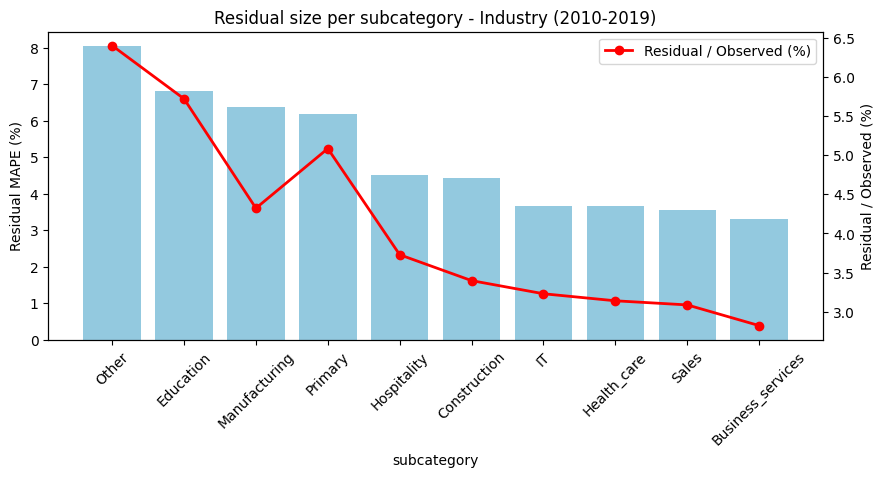

In [29]:
# Check the residuals: uptrend years
inc_resid_check = residual_summary(inc_seasonal_results, category="Industry")
print(inc_resid_check.sort_values("rmse", ascending=False).head(10))

# Residual visualisation
residual_visualisation(
    resid_df=inc_resid_check,
    category="Industry",
    date_start=inc_date_start.year,
    date_end=inc_date_end.year
)

/var/tmp/ipykernel_6061/1160932187.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/tmp/ipykernel_6061/4108730091.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(order, rotation=45)


         subcategory       rmse        mae      mape  resid_to_obs
2          Education  18.862202  10.484512  3.886243      2.975751
3        Health_care  13.055016  10.724205  4.310769      2.338224
7              Other  12.934463   9.312993  4.007675      2.086908
6      Manufacturing   8.186128   6.358580  3.741914      1.865176
8            Primary   8.026452   6.286705  2.136581      1.222556
4        Hospitality   6.636739   5.352988  2.950424      1.610788
1       Construction   6.262739   4.626371  2.789477      1.448886
9              Sales   3.087432   2.453500  3.372325      1.629093
0  Business_services   2.656882   1.624068  3.462301      1.645898
5                 IT   1.642234   1.299132  4.194368      2.065393


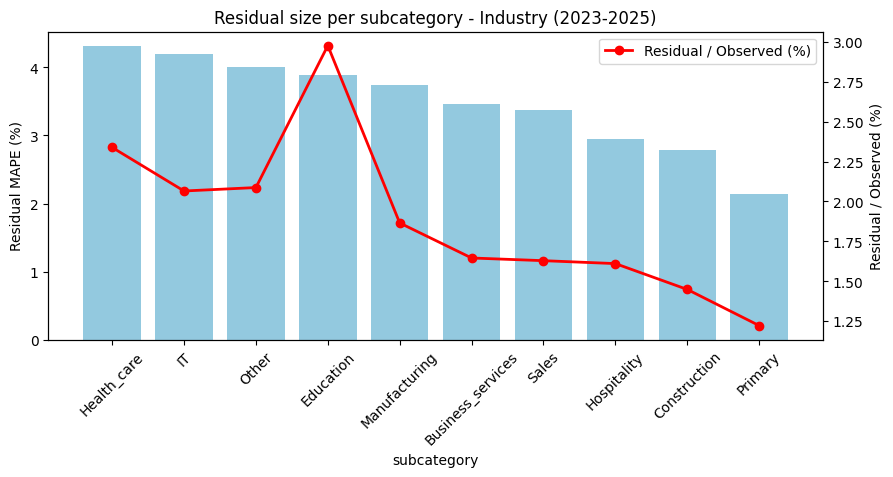

In [30]:
# Check the residuals: downtrend years
dec_resid_check = residual_summary(dec_seasonal_results, category="Industry")
print(dec_resid_check.sort_values("rmse", ascending=False).head(10))

# Residual visualisation
residual_visualisation(
    resid_df=dec_resid_check,
    category="Industry",
    date_start=dec_date_start.year,
    date_end=dec_date_end.year
)
